# Determining the Primary Causes of Traffic Accidents in Chicago

This projects raw dataset originates from the [City of Chicago's website](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if/about_data), where it is updated daily. I downloaded the data on May 1st, 2024 and [uploaded that snapshot to Kaggle](https://www.kaggle.com/datasets/joelmott/chicago-traffic-crashes-may-2024).

This dataset consists of three seperate csv files: one for general crash information, one for the people involved in each crash, and one for each vehicle. When merged, the resulting dataset contains over 150 columns and 3.8 million records. In order to improve modeling results and interpretability, I narrowed that down to 15 feature columns and one target column in this [data engineering notebook](https://github.com/joeldmott/chicago_auto_accidents_project/blob/main/data_engineering_notebook.ipynb).

In this project, I use the resulting csv file from that data engineering effort.

In [1]:
import json
import os
from pathlib import Path
from google.colab import userdata

# api key for importing Kaggle and downloading the datasets
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
# api key for the json object below
api_key = userdata.get('API_KEY')

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

In [2]:
#importing Kaggle module and downloading pre-engineered csv file
import kaggle
! kaggle datasets download joelmott/chicago-traffic-crashes-may-2024 -f trimmed_chicago_crashes_data.csv

Dataset URL: https://www.kaggle.com/datasets/joelmott/chicago-traffic-crashes-may-2024
License(s): CC0-1.0
 47% 5.00M/10.6M [00:00<00:00, 32.3MB/s]
100% 10.6M/10.6M [00:00<00:00, 51.2MB/s]


In [3]:
!unzip /content/trimmed_chicago_crashes_data.csv

Archive:  /content/trimmed_chicago_crashes_data.csv.zip
  inflating: trimmed_chicago_crashes_data.csv  


In [4]:
#reading file in as a DataFrame
import pandas as pd
df = pd.read_csv('/content/trimmed_chicago_crashes_data.csv')
df.head()

,Unnamed: 0,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,ROADWAY_SURFACE_COND,NUM_UNITS,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,PERSON_TYPE,SEX,AGE,TRAVEL_DIRECTION,MANEUVER,TARGET
0,0,30,CLEAR,DAYLIGHT,DRY,2,17,6,8,41.942976,-87.761883,BICYCLE,M,14,S,STRAIGHT AHEAD,1
1,1,30,CLEAR,DAYLIGHT,DRY,2,17,6,8,41.942976,-87.761883,DRIVER,M,36,S,STRAIGHT AHEAD,1
2,2,15,CLEAR,DAYLIGHT,DRY,2,12,4,9,41.744152,-87.585945,DRIVER,M,55,W,BACKING,1
3,3,15,CLEAR,DAYLIGHT,DRY,2,12,4,9,41.744152,-87.585945,DRIVER,M,55,S,SLOW/STOP IN TRAFFIC,1
4,4,30,CLEAR,DAYLIGHT,DRY,2,11,4,9,41.937252,-87.776321,DRIVER,M,39,S,STRAIGHT AHEAD,1


In [5]:
#A new index column was added in for some reason, let's drop that
df.drop('Unnamed: 0', axis=1, inplace=True)
#Now let's check and see if it looks like it did back in the data engineering notebook:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884772 entries, 0 to 884771
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   POSTED_SPEED_LIMIT    884772 non-null  int64  
 1   WEATHER_CONDITION     884772 non-null  object 
 2   LIGHTING_CONDITION    884772 non-null  object 
 3   ROADWAY_SURFACE_COND  884772 non-null  object 
 4   NUM_UNITS             884772 non-null  int64  
 5   CRASH_HOUR            884772 non-null  int64  
 6   CRASH_DAY_OF_WEEK     884772 non-null  int64  
 7   CRASH_MONTH           884772 non-null  int64  
 8   LATITUDE              884772 non-null  float64
 9   LONGITUDE             884772 non-null  float64
 10  PERSON_TYPE           884772 non-null  object 
 11  SEX                   884772 non-null  object 
 12  AGE                   884772 non-null  int64  
 13  TRAVEL_DIRECTION      884772 non-null  object 
 14  MANEUVER              884772 non-null  object 
 15  

## valuation measures

This file is more managable than the gargantuan raw data, but still contains plenty of records. Subsequently, we'll validate this project using a train-test split as opposed to cross-validation.

In [6]:
from sklearn.model_selection import train_test_split
X = df.drop('TARGET', axis=1)
y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=210)

## preprocessing data

Now we can standardize our numeric columns and one-hot encode our categorical ones before inputting these features into models.

In [7]:
#establishing which features are numeric or categorical
numeric_features = ['POSTED_SPEED_LIMIT', 'NUM_UNITS', 'CRASH_HOUR', 'LATITUDE', 'LONGITUDE', 'AGE']

categorical_features = ['WEATHER_CONDITION', 'LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND',
                        'CRASH_DAY_OF_WEEK', 'PERSON_TYPE', 'SEX', 'TRAVEL_DIRECTION', 'MANEUVER']

#splitting them up for preprocessing
X_train_numeric = X_train[numeric_features]
X_train_categorical = X_train[categorical_features]

First, we'll standardize the numeric features since they have varied scales that throw off measures like PCA.

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric)
X_train_numeric_scaled = pd.DataFrame(X_train_numeric_scaled,
                                      columns = X_train_numeric.columns,
                                      index = X_train_numeric.index)
X_train_numeric_scaled.head()

,POSTED_SPEED_LIMIT,NUM_UNITS,CRASH_HOUR,LATITUDE,LONGITUDE,AGE
571273,0.132509,1.141696,-1.013182,0.107484,-0.085609,-1.109211
751169,0.132509,-0.333483,-1.013182,-0.112652,-0.012405,0.459883
43397,0.132509,1.141696,-2.335921,-0.233132,0.113552,-1.046447
847787,0.132509,-0.333483,1.254371,0.310612,-0.137801,-1.485793
542731,0.132509,-0.333483,-0.068368,0.106912,0.022791,0.397120


Looks good; let's one-hot encode the categorical variables. Since we'll be using regularization to optimize our models, we won't need to drop one of the resulting dummy variables. This will help with model interpretability.

In [9]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)
X_train_categorical_ohe = ohe.fit_transform(X_train_categorical)
X_train_categorical_ohe = pd.DataFrame(X_train_categorical_ohe,
                                       columns = ohe.get_feature_names_out(),
                                       index = X_train_categorical.index)
X_train_categorical_ohe.head()

,"WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT",WEATHER_CONDITION_BLOWING SNOW,WEATHER_CONDITION_CLEAR,WEATHER_CONDITION_CLOUDY/OVERCAST,WEATHER_CONDITION_FOG/SMOKE/HAZE,WEATHER_CONDITION_FREEZING RAIN/DRIZZLE,WEATHER_CONDITION_RAIN,WEATHER_CONDITION_SEVERE CROSS WIND GATE,WEATHER_CONDITION_SLEET/HAIL,WEATHER_CONDITION_SNOW,...,MANEUVER_SKIDDING/CONTROL LOSS,MANEUVER_SLOW/STOP - LEFT TURN,MANEUVER_SLOW/STOP - LOAD/UNLOAD,MANEUVER_SLOW/STOP - RIGHT TURN,MANEUVER_SLOW/STOP IN TRAFFIC,MANEUVER_STARTING IN TRAFFIC,MANEUVER_STRAIGHT AHEAD,MANEUVER_TURNING LEFT,MANEUVER_TURNING RIGHT,MANEUVER_U-TURN
571273,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
751169,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
43397,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
847787,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
542731,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [10]:
X_train_categorical_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 707817 entries, 571273 to 303626
Data columns (total 63 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT   707817 non-null  float64
 1   WEATHER_CONDITION_BLOWING SNOW               707817 non-null  float64
 2   WEATHER_CONDITION_CLEAR                      707817 non-null  float64
 3   WEATHER_CONDITION_CLOUDY/OVERCAST            707817 non-null  float64
 4   WEATHER_CONDITION_FOG/SMOKE/HAZE             707817 non-null  float64
 5   WEATHER_CONDITION_FREEZING RAIN/DRIZZLE      707817 non-null  float64
 6   WEATHER_CONDITION_RAIN                       707817 non-null  float64
 7   WEATHER_CONDITION_SEVERE CROSS WIND GATE     707817 non-null  float64
 8   WEATHER_CONDITION_SLEET/HAIL                 707817 non-null  float64
 9   WEATHER_CONDITION_SNOW                       707817 non-nul

In [11]:
X_train_preprocessed = pd.concat([X_train_numeric_scaled, X_train_categorical_ohe], axis=1)
X_train_preprocessed.head()

,POSTED_SPEED_LIMIT,NUM_UNITS,CRASH_HOUR,LATITUDE,LONGITUDE,AGE,"WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT",WEATHER_CONDITION_BLOWING SNOW,WEATHER_CONDITION_CLEAR,WEATHER_CONDITION_CLOUDY/OVERCAST,...,MANEUVER_SKIDDING/CONTROL LOSS,MANEUVER_SLOW/STOP - LEFT TURN,MANEUVER_SLOW/STOP - LOAD/UNLOAD,MANEUVER_SLOW/STOP - RIGHT TURN,MANEUVER_SLOW/STOP IN TRAFFIC,MANEUVER_STARTING IN TRAFFIC,MANEUVER_STRAIGHT AHEAD,MANEUVER_TURNING LEFT,MANEUVER_TURNING RIGHT,MANEUVER_U-TURN
571273,0.132509,1.141696,-1.013182,0.107484,-0.085609,-1.109211,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
751169,0.132509,-0.333483,-1.013182,-0.112652,-0.012405,0.459883,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
43397,0.132509,1.141696,-2.335921,-0.233132,0.113552,-1.046447,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
847787,0.132509,-0.333483,1.254371,0.310612,-0.137801,-1.485793,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
542731,0.132509,-0.333483,-0.068368,0.106912,0.022791,0.397120,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [12]:
X_train_preprocessed.shape

(707817, 69)

That's still too many columns, but I can't drop any more in good conscience without further information. Let's make use of Principal Component Analysis (PCA) to which features are more significant.

In [24]:
from sklearn.decomposition import PCA
pca = PCA(random_state=210)
pca_array = pca.fit_transform(X_train_preprocessed)
pca_array

array([[-1.33546501e-01,  8.37875659e-01,  1.33035957e+00, ...,
         1.63263119e-14, -1.04521151e-14, -2.72348349e-15],
       [ 7.45724224e-02, -7.11396080e-01,  8.67243498e-01, ...,
         1.05148879e-14,  2.63398316e-14,  1.47182162e-14],
       [ 2.52991872e-01,  6.12658192e-01,  2.25054622e+00, ...,
        -5.80594613e-15,  2.23024165e-14, -5.40001772e-15],
       ...,
       [ 1.01928195e-01, -1.02117000e+00,  9.33134998e-01, ...,
        -3.65539377e-17, -5.19572472e-18,  4.14075590e-17],
       [ 3.49421039e-01,  7.03979332e-02, -3.70697133e-01, ...,
        -1.68710620e-17, -2.08849482e-17,  2.59569713e-17],
       [ 2.53640988e-01, -5.58348152e-01, -2.24439449e-01, ...,
        -1.06584771e-17,  3.39795214e-17,  6.76586431e-17]])

In [25]:
len(pca_array)

707817

Now that we've fit PCA to our training data, let's see how much of the variance it explains by adding up each row's explained variance ratio.

In [26]:
import numpy as np
evr = pca.explained_variance_ratio_
np.cumsum(evr)

array([0.19978425, 0.31013649, 0.41337286, 0.51236511, 0.60727314,
       0.65673974, 0.70265202, 0.73364186, 0.761715  , 0.78651999,
       0.81021641, 0.83299294, 0.84940415, 0.86419541, 0.87883346,
       0.89324448, 0.90712431, 0.91875691, 0.92827092, 0.93730983,
       0.94387062, 0.95010009, 0.95578929, 0.95976791, 0.9634321 ,
       0.96693294, 0.9703201 , 0.9734249 , 0.97594635, 0.97837396,
       0.98069592, 0.98257593, 0.98431272, 0.98593332, 0.98754699,
       0.98909716, 0.9904115 , 0.99161978, 0.99270955, 0.99375646,
       0.99457928, 0.99538291, 0.99606826, 0.99665373, 0.99716292,
       0.99765165, 0.99800998, 0.9983545 , 0.99863401, 0.99884497,
       0.99905226, 0.99922076, 0.99938749, 0.99952536, 0.99964994,
       0.99977387, 0.99988918, 0.99996568, 0.9999844 , 0.99999953,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

Not great, let's check out the loadings to see how the features contribute.

In [27]:
loadings = pca.components_
print('Loadings shape:', loadings.shape)
print(np.around(loadings, decimals=3))

Loadings shape: (69, 69)
[[ 0.005  0.004 -0.001 ...  0.    -0.     0.   ]
 [ 0.605  0.554  0.308 ... -0.003 -0.006 -0.   ]
 [ 0.166  0.43  -0.866 ... -0.01  -0.004 -0.001]
 ...
 [ 0.     0.    -0.    ...  0.14   0.14   0.14 ]
 [-0.    -0.     0.    ...  0.075  0.075  0.075]
 [ 0.     0.    -0.    ... -0.013 -0.013 -0.013]]


I thought PCA combines features; why do I have all 69 here in both PC's?

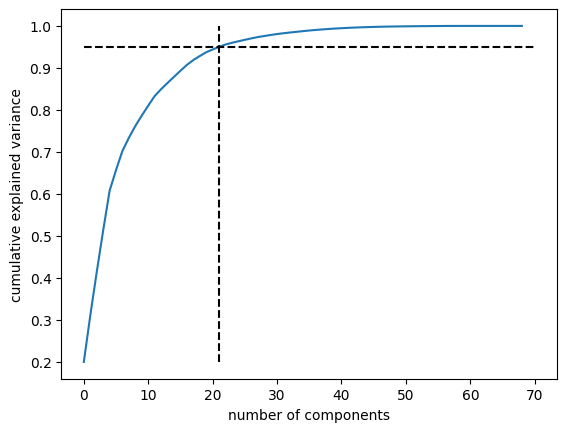

In [35]:
from matplotlib import pyplot as plt
plt.plot(np.cumsum(evr))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.hlines(y=0.95, xmin=0, xmax=70, color='k', linestyle='--')
plt.vlines(x=21, ymin=0.2, ymax=1, color='k', linestyle='--');

In [36]:
pca = PCA(n_components=21, random_state=210)
pca_array = pca.fit_transform(X_train_preprocessed)
evr = pca.explained_variance_ratio_
np.cumsum(evr)

array([0.19978425, 0.31013649, 0.41337286, 0.51236511, 0.60727314,
       0.65673974, 0.70265202, 0.73364186, 0.761715  , 0.78651999,
       0.81021641, 0.83299294, 0.84940415, 0.86419541, 0.87883346,
       0.89324448, 0.90712431, 0.9187569 , 0.92827092, 0.93730982,
       0.94387058])

In [37]:
loadings = pca.components_
print('Loadings shape:', loadings.shape)
print(np.around(loadings, decimals=3))

Loadings shape: (21, 69)
[[ 0.005  0.004 -0.001 ...  0.    -0.     0.   ]
 [ 0.605  0.554  0.308 ... -0.003 -0.006 -0.   ]
 [ 0.166  0.43  -0.866 ... -0.01  -0.004 -0.001]
 ...
 [-0.002 -0.025  0.002 ... -0.588 -0.043 -0.006]
 [ 0.009  0.009  0.007 ...  0.172  0.016 -0.   ]
 [ 0.003 -0.    -0.026 ... -0.086  0.034  0.002]]


In [40]:
loadings_rounded = np.around(loadings, decimals=3)
pd.DataFrame(loadings_rounded,columns=X_train_preprocessed.columns)

,POSTED_SPEED_LIMIT,NUM_UNITS,CRASH_HOUR,LATITUDE,LONGITUDE,AGE,"WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT",WEATHER_CONDITION_BLOWING SNOW,WEATHER_CONDITION_CLEAR,WEATHER_CONDITION_CLOUDY/OVERCAST,...,MANEUVER_SKIDDING/CONTROL LOSS,MANEUVER_SLOW/STOP - LEFT TURN,MANEUVER_SLOW/STOP - LOAD/UNLOAD,MANEUVER_SLOW/STOP - RIGHT TURN,MANEUVER_SLOW/STOP IN TRAFFIC,MANEUVER_STARTING IN TRAFFIC,MANEUVER_STRAIGHT AHEAD,MANEUVER_TURNING LEFT,MANEUVER_TURNING RIGHT,MANEUVER_U-TURN
0,0.005,0.004,-0.001,-0.707,0.707,0.005,0.0,-0.000,0.000,-0.000,...,-0.000,-0.000,-0.000,-0.000,0.001,0.000,0.001,0.000,-0.000,0.000
1,0.605,0.554,0.308,0.002,-0.002,-0.457,-0.0,0.001,-0.010,-0.003,...,0.000,0.000,-0.000,-0.000,0.012,-0.000,0.017,-0.003,-0.006,-0.000
2,0.166,0.430,-0.866,0.003,-0.003,0.118,0.0,0.000,-0.016,0.009,...,0.001,0.000,-0.000,-0.000,0.013,-0.000,-0.007,-0.010,-0.004,-0.001
3,0.355,0.178,0.276,0.004,-0.005,0.872,-0.0,0.000,0.009,-0.001,...,-0.001,0.000,-0.000,0.000,0.010,0.000,0.010,-0.003,-0.002,-0.000
4,-0.687,0.685,0.215,-0.002,-0.002,0.072,0.0,0.001,0.011,-0.002,...,-0.001,0.000,0.000,0.000,0.016,-0.001,-0.051,-0.015,-0.006,-0.002
5,-0.038,-0.030,-0.045,0.005,0.010,-0.024,0.0,0.000,-0.138,0.007,...,0.003,-0.000,0.000,0.000,-0.007,-0.000,-0.004,0.000,0.000,0.001
6,-0.026,-0.007,-0.010,-0.003,-0.003,0.057,-0.0,0.001,-0.482,0.037,...,0.006,0.000,-0.000,-0.000,0.002,-0.001,0.021,-0.001,-0.003,-0.001
7,-0.032,-0.032,-0.168,-0.004,-0.002,0.080,-0.0,0.000,0.149,-0.036,...,-0.001,-0.000,-0.000,-0.000,-0.042,-0.002,0.059,-0.010,-0.004,-0.000
8,-0.044,0.032,0.009,-0.008,-0.009,-0.002,0.0,0.000,0.004,-0.005,...,-0.009,-0.005,-0.002,-0.003,-0.270,-0.014,0.920,-0.214,-0.080,-0.015
9,-0.005,-0.002,0.020,-0.000,0.004,0.000,0.0,0.000,0.001,-0.001,...,-0.000,-0.000,0.000,-0.000,0.002,0.000,0.007,-0.004,-0.003,-0.000
